In [ ]:
# prompt: connect google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load Libraries **

In [ ]:
!pip install tensorflow  # Make sure TensorFlow is installed
!pip install keras        # Make sure Keras is installed

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
#from keras.preprocessing.text import one_hot  # This is likely causing the error
from tensorflow.keras.preprocessing.text import one_hot # Import from tensorflow.keras.preprocessing.text
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences  # This might also be moved to tensorflow.keras
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
import numpy as np
import pickle
import nltk
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
import pandas as pd # Make sure pandas is imported

train_data = pd.read_csv('/content/drive/MyDrive/NLP PROject/topical_chat.csv') # Call the read_csv function from pandas using pd.read_csv

In [ ]:
train_data.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [ ]:
train_data.shape

(188378, 3)

In [ ]:
train_data.isnull().sum()


,0
conversation_id,0
message,0
sentiment,0


In [ ]:
train_data.duplicated().sum()

30

**EDA**

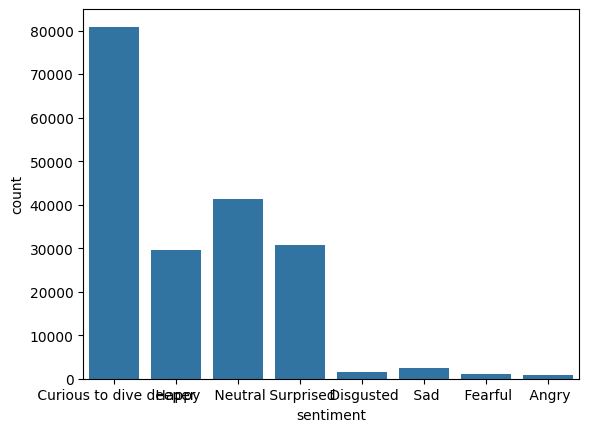

In [ ]:
sns.countplot(x = train_data['sentiment'])
plt.show()

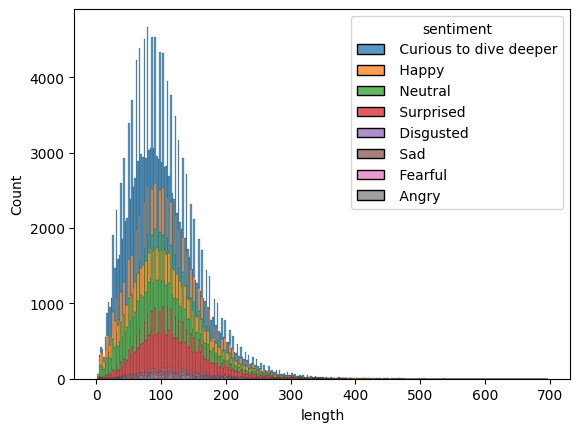

In [ ]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['message']]

# Convert the 'length' column to a numpy array
length_values = df2['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
sns.histplot(data=df2, x='length', hue='sentiment', multiple='stack')

plt.show()

In [ ]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");
sentiment_list = train_data['sentiment'].unique()
for sentiment in sentiment_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['sentiment'] == sentiment,'message']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, sentiment)

# **Data Preprocessing**

In [ ]:
lb = LabelEncoder()
train_data['sentiment'] = lb.fit_transform(train_data['sentiment'])

In [ ]:
train_data

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,1
1,1,Both are excellent technology they are helpfu...,1
2,1,"I'm not a huge fan of Google, but I use it a...",1
3,1,Google provides online related services and p...,1
4,1,"Yeah, their services are good. I'm just not a...",1
...,...,...,...
188373,8628,"Wow, it does not seem like that long. Since I...",7
188374,8628,"I havent seen that episode, I might google it...",1
188375,8628,I don't think I have either. That's an insane...,1
188376,8628,"I did, my little brother used to love Thomas ...",4


In [ ]:
df = train_data.copy()

In [ ]:
df

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,1
1,1,Both are excellent technology they are helpfu...,1
2,1,"I'm not a huge fan of Google, but I use it a...",1
3,1,Google provides online related services and p...,1
4,1,"Yeah, their services are good. I'm just not a...",1
...,...,...,...
188373,8628,"Wow, it does not seem like that long. Since I...",7
188374,8628,"I havent seen that episode, I might google it...",1
188375,8628,I don't think I have either. That's an insane...,1
188376,8628,"I did, my little brother used to love Thomas ...",4


In [ ]:
# Data cleaning and preprocessing
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_message'] = df['message'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Encode emotions**

In [ ]:
train_data

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,1
1,1,Both are excellent technology they are helpfu...,1
2,1,"I'm not a huge fan of Google, but I use it a...",1
3,1,Google provides online related services and p...,1
4,1,"Yeah, their services are good. I'm just not a...",1
...,...,...,...
188373,8628,"Wow, it does not seem like that long. Since I...",7
188374,8628,"I havent seen that episode, I might google it...",1
188375,8628,I don't think I have either. That's an insane...,1
188376,8628,"I did, my little brother used to love Thomas ...",4


# **Applying Deeping Learning Using LSTM**




**Text Cleaning, Ecoding, and Padding**

In [ ]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "message", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["sentiment"])

**Model Building and Training**

In [ ]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
# Change the number of units in the final Dense layer to match the number of classes in y_train (8)
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=18, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - accuracy: 0.4269 - loss: 1.4139
Epoch 2/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.4845 - loss: 1.2703
Epoch 3/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.5105 - loss: 1.2170
Epoch 4/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - accuracy: 0.5267 - loss: 1.1851
Epoch 5/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 83s 20ms/step - accuracy: 0.5461 - loss: 1.1433
Epoch 6/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.5606 - loss: 1.1093
Epoch 7/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - accuracy: 0.5744 - loss: 1.0779
Epoch 8/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - accuracy: 0.5883 - loss: 1.0440
Epoch 9/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - accuracy: 0.6018 - loss: 1.0116
Epoch 10/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - accuracy: 0.6141 - loss: 0.9805
Epoch 11/18
2944/2944 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.6252 - loss: 0.9531
Epoch 12

In [ ]:
 # Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Curious to dive deeper : 0.633346438407898


im grabbing a minute to post i feel greedy wrong
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Neutral : 0.7763707041740417


He was speechles when he found out he was accepted to this new job
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 Neutral : 0.8157009482383728


This is outrageous, how can you talk like that?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Neutral : 0.35241058468818665


I feel like im all alone in this world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Happy : 0.4083804488182068


He is really sweet and caring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Happy : 0.43738245964050293


You made me very crazy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

**Save the model and files**

In [ ]:
model.save('model1.h5')

# Save the LabelEncoder
with open('lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)

In [ ]:
# use this version
import tensorflow
import keras
print(keras.__version__)
print(tensorflow.__version__)

3.4.1
2.17.0
